# Emotion Diary Project - Hugging Face

<hr>

**Imports**

In [98]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

Enabling GPU

In [99]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [100]:
plt.style.use('ggplot')

**DistilBERT Model**

https://huggingface.co/distilbert-base-uncased

In BERT uncased, the text has been lowercased before WordPiece tokenization step while in BERT cased, the text is same as the input text (no changes). For example, if the input is "OpenGenus", then it is converted to "opengenus" for BERT uncased while BERT cased takes in "OpenGenus".

In [101]:
MODEL_NAME = 'distilbert-base-cased'    

### Loading Data

In [102]:
df = pd.read_csv('Emotion_final.csv', encoding = "UTF-8", encoding_errors='ignore')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [103]:
from sklearn.model_selection import train_test_split

train_df,  test_df= train_test_split(df, test_size=0.33, random_state=42)

In [104]:
train_df.head()

,Text,Emotion
9586,i had not yet gotten married and that coupled ...,anger
5847,im feeling cautiously optimistic about the dir...,happy
1681,i felt such a resonance with your words i feel...,sadness
1452,i like this so much but i feel like somehow th...,happy
15890,i don t feel particularly passionate as i once...,happy


In [105]:
test_df.head()

,Text,Emotion
20248,"There was amusement in Jake 's voice , but the...",happy
8094,i feel it is too dangerous to invest in such m...,anger
2859,i feel that i should write the company and tel...,sadness
18953,i also feel ashamed at the hurt caused and ash...,sadness
3931,i just yearned for that homey feeling where yo...,love


*Dropping any duplicates or missing values*

In [106]:
train_df.drop_duplicates(inplace= True)
test_df.drop_duplicates(inplace=True)

In [107]:
train_df.isna().sum()

Text       0
Emotion    0
dtype: int64

In [108]:
test_df.isna().sum()

Text       0
Emotion    0
dtype: int64

Because a missing location is not as important as a missing tweet or sentiment, I will not remove those entires.

In [109]:
print(f"There are {train_df.shape[0]} entries in the training dataframe")
train_df.head()

There are 14375 entries in the training dataframe


,Text,Emotion
9586,i had not yet gotten married and that coupled ...,anger
5847,im feeling cautiously optimistic about the dir...,happy
1681,i felt such a resonance with your words i feel...,sadness
1452,i like this so much but i feel like somehow th...,happy
15890,i don t feel particularly passionate as i once...,happy


In [110]:
print(f"There are {test_df.shape[0]} entries in the test dataframe")
test_df.head()

There are 7082 entries in the test dataframe


,Text,Emotion
20248,"There was amusement in Jake 's voice , but the...",happy
8094,i feel it is too dangerous to invest in such m...,anger
2859,i feel that i should write the company and tel...,sadness
18953,i also feel ashamed at the hurt caused and ash...,sadness
3931,i just yearned for that homey feeling where yo...,love


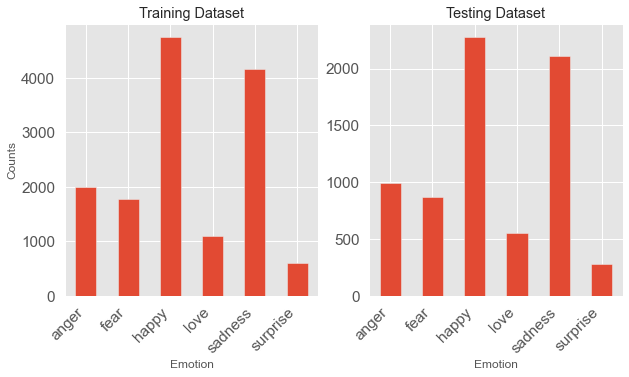

In [111]:
reorder = ['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Emotion').reindex(index=reorder).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')

test_df.value_counts('Emotion').reindex(index=reorder).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Dataset');

It looks like the training and testsing datasets are not balanced across all categories.

In [112]:
max_words = []
for row in train_df['Text']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 66


**Getting rid of the URL's in the tweets**

In [113]:
test_str = test_df['Text'][0]
print(test_str)

def remove_https(row):
    return re.sub(r'http\S+', '', row)

remove_https(test_str)

i didnt feel humiliated


'i didnt feel humiliated'

*Apply to whole datasets*

In [114]:
train_df['Text_no_URL'] = train_df['Text'].apply(remove_https)
test_df['Text_no_URL'] = test_df['Text'].apply(remove_https)

**Label Encode the datasets**

In [115]:
le = LabelEncoder()
train_df['Sentiment_label'] = le.fit_transform(train_df['Emotion'])
test_df['Sentiment_label'] = le.transform(test_df['Emotion'])

In [116]:
label_dict = (test_df[['Emotion','Sentiment_label']].drop_duplicates()
              .sort_values(by='Sentiment_label')
              .reset_index(drop=True)['Emotion']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 anger
1 fear
2 happy
3 love
4 sadness
5 surprise


**Splitting the data**

I will take 20% of the training data as validation data

In [117]:
# Get the number training samples
num_train_samples = int(train_df.shape[0] * 0.8)

x_train = train_df['Text_no_URL'][:num_train_samples]
y_train = train_df['Sentiment_label'][:num_train_samples]
x_val = train_df['Text_no_URL'][num_train_samples:]
y_val = train_df['Sentiment_label'][num_train_samples:]

### Sanity Check
assert(len(x_train) + len(x_val) == train_df.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")

11500 training examples
2875 validation examples


In [145]:
y_train

9586     0
5847     2
1681     4
1452     2
15890    2
        ..
6990     2
19559    4
17858    0
1823     0
10081    2
Name: Sentiment_label, Length: 11500, dtype: int32

In [118]:
x_test = test_df['Text_no_URL']
y_test = test_df['Sentiment_label']
print(f"{len(x_test)} testing examples")

7082 testing examples


## DistilBERT

**Tokenize the Inputs** 

In [124]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

*Finding the max token sequence in the training set*

In [125]:
max_val = 0
for sent in (x_train.tolist() + x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 92


I will set the max length and input for the deep learning model to 100  


In [134]:
MAX_LENGTH = 100

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [135]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

100%|██████████| 2875/2875 [00:01<00:00, 1658.05it/s]


**Looking at entry**

In [136]:
train_df.head()

,Text,Emotion,Text_no_URL,Sentiment_label
9586,i had not yet gotten married and that coupled ...,anger,i had not yet gotten married and that coupled ...,0
5847,im feeling cautiously optimistic about the dir...,happy,im feeling cautiously optimistic about the dir...,2
1681,i felt such a resonance with your words i feel...,sadness,i felt such a resonance with your words i feel...,4
1452,i like this so much but i feel like somehow th...,happy,i like this so much but i feel like somehow th...,2
15890,i don t feel particularly passionate as i once...,happy,i don t feel particularly passionate as i once...,2


In [137]:
index_num = 2

print(train_df.loc[index_num]['Emotion'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

anger 

im grabbing a minute to post i feel greedy wrong 

ID's	Input Tokens
101	[CLS]
13280	im
10810	grabbing
170	a
2517	minute
1106	to
2112	post
178	i
1631	feel
24007	greedy
2488	wrong
102	[SEP]


### Creating the model

In [139]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, n_layers = 2)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)



In [140]:
input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(6, activation='softmax')(X) # MZ: change to 6 classes

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model_12 (TFDis  TFBaseModelOutput(l  36839424   ['input_token[0][0]',            
 tilBertModel)                  ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 100, 768),                                                   
                                 hidden_states=((No                                           

*Creating a output directory to store the models weights*

In [141]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

*Callbacks*

In [142]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

**Compile and train**

In [143]:
import tensorflow_addons as tfa

In [148]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
719/719 [==============================] - 491s 676ms/step - loss: 0.9216 - accuracy: 0.6610 - val_loss: 0.4085 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 2/10
719/719 [==============================] - 472s 656ms/step - loss: 0.2873 - accuracy: 0.8970 - val_loss: 0.2445 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 3/10
719/719 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9290
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
719/719 [==============================] - 462s 643ms/step - loss: 0.1862 - accuracy: 0.9290 - val_loss: 0.2425 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 4/10
719/719 [==============================] - 457s 636ms/step - loss: 0.1028 - accuracy: 0.9634 - val_loss: 0.1971 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 5/10
719/719 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9690
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
719/719 [================

Plotting the training accuracy and loss

Lowest Validation Loss: epoch 5
Highest Validation Accuracy: epoch 6


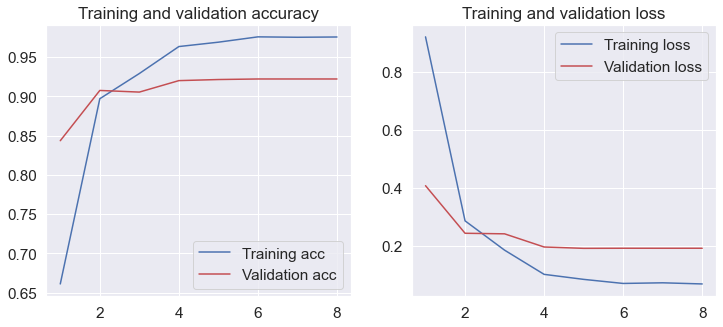

In [149]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

Loading the model with the best validation accuracy

In [150]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [151]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Making inference on the test data**

In [152]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

**Results**

Accuracy: 0.9207850889579214


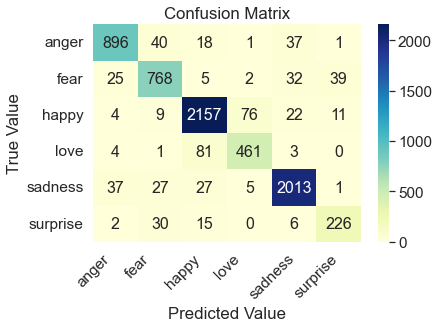

In [153]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [155]:
print('Hugging face: distilbert-base-cased')
print('accuracy %s' % accuracy_score(y_hat, y_test))
print(classification_report(y_test, y_hat, target_names=labels_6))

Hugging face: distilbert-base-cased
accuracy 0.9207850889579214
              precision    recall  f1-score   support

       anger       0.93      0.90      0.91       993
        fear       0.88      0.88      0.88       871
       happy       0.94      0.95      0.94      2279
        love       0.85      0.84      0.84       550
     sadness       0.95      0.95      0.95      2110
    surprise       0.81      0.81      0.81       279

    accuracy                           0.92      7082
   macro avg       0.89      0.89      0.89      7082
weighted avg       0.92      0.92      0.92      7082

